In [1]:
#Imports
import nilearn 
import pandas as pd
import numpy as np 
import nibabel as nib
import glob
import matplotlib.pyplot as plt

from nilearn import plotting, image
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import compute_regressor
from nilearn.glm.first_level import make_first_level_design_matrix

from nilearn.plotting import plot_design_matrix

# Data path
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
mask = '/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii'


index: 0
subj: 200100
TR: 2.0
n stim: 3
stim duration: 20
Contrasts:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)


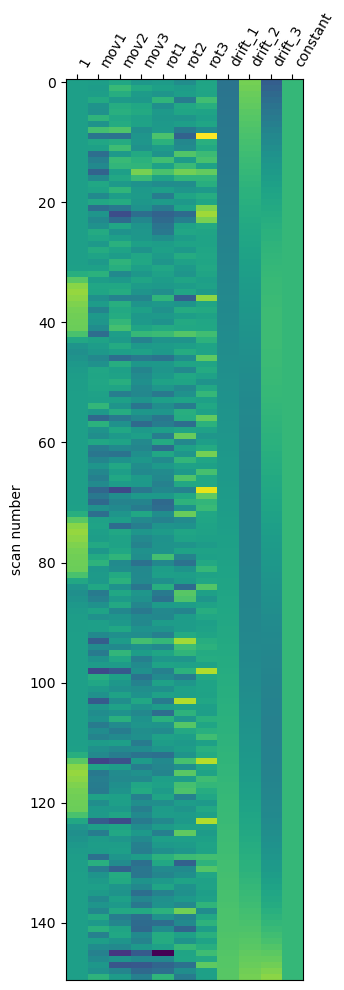

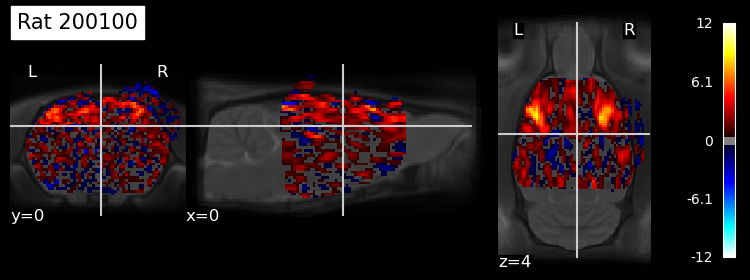

In [2]:
# ---------- FIRST LEVEL ANALYSIS ------------
# ---------------- Glover HRF -------------------

df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

for index in range(0, 1):
    
    subj_num=str(df.iloc[index]['rat.sub'])[:-2]
    print('index:', index)
    print('subj:', subj_num)
    
    subject_path = glob.glob(analysis_folder + "/sub-0{}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, subj_num, subj_num))[0]    
    func_img = nib.load(subject_path)                                

    
    # --- Events regressor --- 
    
    tr = (df.iloc[index]['func.TR']) 
    n_tr = np.count_nonzero((np.matrix(df.iloc[index]['func.sensory.onset'])))   #count number of stimulation, number of onset
    duration = int(df.loc[index, 'func.sensory.duration'].split(',')[0].strip())

    n_scans = func_img.shape[3]    
    frame_times = np.arange(n_scans) * tr                             # corresponding frame times    
    
    onset = np.matrix(df.iloc[index]['func.sensory.onset']).A[0]
    durations = np.matrix(df.iloc[index]['func.sensory.duration']).A[0]
    trial_type = np.ones_like(onset)
    events = pd.DataFrame({'onset': onset,'duration': durations, 'trial_type': trial_type})
    
    print('TR:', tr)
    print('n stim:', n_tr)
    print('stim duration:', duration)  
    
    
    # --- Motion regressors ---

    cofounders_file = 'sub-0{}_ses-1_run-1_bold_RAS_combined_confounds.csv'.format(subj_num)
    cofounders_path = glob.glob(analysis_folder +"/sub-0{}_ses-1/confounds_datasink/confounds_csv/*/*/*.csv".format(subj_num, subj_num, subj_num, subj_num))[0]


    cofounders = pd.read_csv(cofounders_path, sep=',')

    motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
    motion = np.array(cofounders[motion_names])
    
    
    # --- Compute design matrix --- 
   
    design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                   events=events, 
                                                   add_regs=motion, 
                                                   add_reg_names=motion_names, 
                                                   drift_model="polynomial", 
                                                   drift_order=3, 
                                                   hrf_model='glover',
                                                   high_pass=0.01)
    plot_design_matrix(design_matrix) 


    # --- Fitting a first-level model ----  
    
    fmri_glm = FirstLevelModel(t_r=tr,
                               drift_model='polynomial',
                               signal_scaling=False,
                               minimize_memory=False)
    
    fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)

    residuals = fmri_glm.residuals[0]
    predicted_timeseries = fmri_glm.predicted[0]
    
        
    # -- Coompute contrasts ---
    
    n_columns = design_matrix.shape[1]
    contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))
    print('Contrasts: ', contrast_val)

    statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')
    
    
    #-- Plot and save as nifti file ---

    plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                       bg_img = template_path, 
                                       threshold = 0.5, 
                                       title = 'Rat {}'.format(subj_num))
    


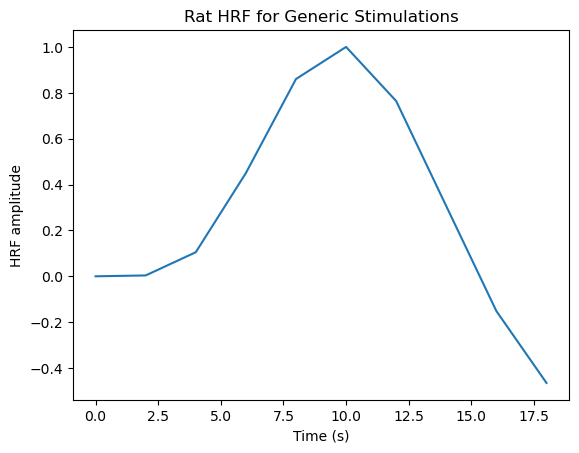

array([ 0.        ,  0.00371357,  0.10489022,  0.45004822,  0.8600431 ,
        1.        ,  0.76399407,  0.30584187, -0.15163822, -0.46485964])

In [3]:
# --- Generic rat HRF: stim >5sec --- 

    #Rref
#Matlab script H. Lambert (2019)        
#https://app.codecov.io/gh/nilearn/nilearn/pull/2942/blob/nilearn/glm/first_level/hemodynamic_models.py

#Evaluating the difference of two gamma probability density functions (PDFs)
# duration : stimulation duration in seconds
# tr : in seconds
# h1, h2, l1, and l2 : define the shape and scale parameters
# V = ratio parameter 

from scipy.stats import gamma

def rat_hrf_generic(duration, tr):
    h1 = 3.7
    h2 = 4.45
    l1 = 0.5
    l2 = 0.5
    V = 1.5
    onset = 0
    kernel_length = int(duration / tr)

    t = np.arange(kernel_length) * tr
    hrf = (gamma.pdf(t, h1 / l1, scale=1 / l1) - gamma.pdf(t, h2 / l2, scale=1 / l2)) / V
    
    # Normalize the HRF to have a peak amplitude of 1
    hrf /= np.max(hrf)

    plt.plot(t, hrf)
    plt.xlabel('Time (s)')
    plt.ylabel('HRF amplitude')
    plt.title('Rat HRF for Generic Stimulations')
    plt.show()
    
    return hrf

rat_hrf_generic(20, 2.0)

index: 0
subj: 200100
TR: 2.0
n stim: 3
stim duration: 20


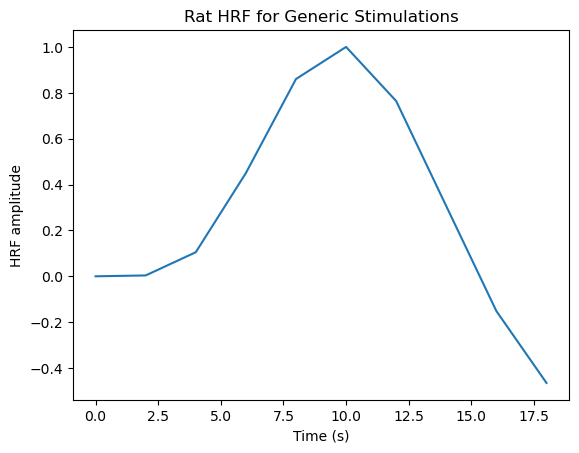

/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/glm/first_level/hemodynamic_models.py:473: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if hrf_model == 'spm':
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/glm/first_level/hemodynamic_models.py:475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif hrf_model == 'spm + derivative':
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/glm/first_level/hemodynamic_models.py:478: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif hrf_model == 'spm + derivative + dispersion':
/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/glm/first_level/hemodynamic_models.py:4

ValueError: "[ 0.          0.00371357  0.10489022  0.45004822  0.8600431   1.
  0.76399407  0.30584187 -0.15163822 -0.46485964]" is not a known hrf model. Use either a custom model or one of ['spm', 'spm + derivative', 'spm + derivative + dispersion', 'fir', 'glover', 'glover + derivative', 'glover + derivative + dispersion', None]

In [5]:
# ---------- FIRST LEVEL ANALYSIS ------------
# ---------------- Rat HRF -------------------

df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

for index in range(0, 1):
    
    subj_num=str(df.iloc[index]['rat.sub'])[:-2]
    print('index:', index)
    print('subj:', subj_num)
    
    subject_path = glob.glob(analysis_folder + "/sub-0{}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, subj_num, subj_num))[0]    
 

    # --- Specify the rat hrf --- 
    
    tr = (df.iloc[index]['func.TR']) 
    n_tr = np.count_nonzero((np.matrix(df.iloc[index]['func.sensory.onset'])))   #count number of stimulation, number of onset
    duration = int(df.loc[index, 'func.sensory.duration'].split(',')[0].strip())
    
    print('TR:', tr)
    print('n stim:', n_tr)
    print('stim duration:', duration)

    rat_model = rat_hrf_generic(duration, tr)
        
    func_img = nib.load(subject_path)                                

    n_scans = func_img.shape[3]    
    frame_times = np.arange(n_scans) * tr                             # corresponding frame times    
       
        
    # --- Events regressor --- 
    
    onset = np.matrix(df.iloc[index]['func.sensory.onset']).A[0]
    durations = np.matrix(df.iloc[index]['func.sensory.duration']).A[0]
    trial_type = np.ones_like(onset)
    events = pd.DataFrame({'onset': onset,'duration': durations, 'trial_type': trial_type})
    
    
    # --- Motion regressors ---

    cofounders_file = 'sub-0{}_ses-1_run-1_bold_RAS_combined_confounds.csv'.format(subj_num)
    cofounders_path = glob.glob(analysis_folder +"/sub-0{}_ses-1/confounds_datasink/confounds_csv/*/*/*.csv".format(subj_num, subj_num, subj_num, subj_num))[0]


    cofounders = pd.read_csv(cofounders_path, sep=',')

    motion_names = ['mov1', 'mov2', 'mov3', 'rot1', 'rot2', 'rot3']
    motion = np.array(cofounders[motion_names])
    
    
    # --- Compute design matrix --- 
   
    design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                   events=events, 
                                                   add_regs=motion, 
                                                   add_reg_names=motion_names, 
                                                   drift_model="polynomial", 
                                                   drift_order=3, 
                                                   hrf_model=rat_model,
                                                   high_pass=0.01)
    plot_design_matrix(design_matrix) 


    # --- Fitting a first-level model ----  
    
    fmri_glm = FirstLevelModel(t_r=tr,
                               drift_model='polynomial',
                               signal_scaling=False,
                               minimize_memory=False)
    
    fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)

    residuals = fmri_glm.residuals[0]
    predicted_timeseries = fmri_glm.predicted[0]
    
        
    # -- Coompute contrasts ---
    
    n_columns = design_matrix.shape[1]
    contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))
    print('Contrasts: ', contrast_val)

    statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')
    
    
    #-- Plot and save as nifti file ---

    plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                       bg_img = template_path, 
                                       threshold = 0.5, 
                                       title = 'Rat {}'.format(subj_num))
    
